1. Importing the data. eda.ipynb

ISSUES WE FOUND:

 - There were codes that were only numerical and when exported, they transformed into cientific notation, for example, '01094403450101' would appear as '09E+12' and we had to export in a different way the codes from the descriptions.
 - When exporting from the program the codes and descriptions of products, we obtained the following symbol "�" replacing some letters like Ñ, for example, instead of BAÑERA we would get BA�ERA.
 - We dropped some columns that were created out of an error generated from exporting the data. We manually sorted the issues generated from that error.
 - We checked the null values.
 - We are given the followin dataset shape: (764396, 8)
 - We get rid of all instances containing the word "DSCTL" in the description.
 - We get rid of all instances where the ARTICULO is null, for those are not products.
 - We neutralise the returned items from the previous purchases or eliminate those returns where no purchases are done from the customer since 2021 (we get rid of 43.126 instances).
 - We generate a unique invoice number from the serie and number to diferentiate transactions with the same date.
 - We generate the annual frecuency purchases of each customer.
 - As we only have 9 months from 2024, we divide the result by 9 and multiply it by 12 to get an annual estimate value.
 - We generate the annual total sales per customer.
 - We clean details to make sure the data looks proper.
 - We add the group of the products to the instances.
 - We drop products without a group (after checking them, they had 0 units selected as well, therefore they were not relevant here).
 - We add the manufacturer to the instances of the products.
 - We notice that after adding the information, we detect null values generated in the new columns, after reviewing them, we detect codes that are not relevant and are dropped.
 - We add the customer groups value the company has already previously generated by their line of work (plumber, electrician, construction company...)
 - We add the customer data information, as when they started working with us, city where they're stablished and so on.

2. Preparing the data for the clustering. post_eda.ipynb

- We check the ditribution of the manufacturers, we find it right skewed by a lot by units.
- We identify we have many manufacturers that have sold only one unit of an item during the last 4 years analysed with us. We decide to reduce the data and concentrate on those manufacturers that the company considers they are aiming to keep a good relatinoship with. The reduction went from 300 manufacturers to a top 99. (Those that sold at least 1000 items)
- We check the distribution of the codigo_familia too.
- We average the annual data to obtain a unique value for the posterior pivoting of the tables.
- We discover a high correlation between FRECUENCIA_ANUAL_MEDIA', 'VENTA_ANUAL_2021', 'VENTA_ANUAL_2022', 'VENTA_ANUAL_2023' and 'VENTA_ANUAL_2024', we decided to keep the FRECUENCIA_ANUAL_MEDIA, for the boxplot showed a more reasonable distribution (for the value of products multiply the final value and created more outliers).
- We checked the distribution amongst customers and items purchased. There is a clear bigger ammount of customers that buy less items, and a few very big customers.
Frecuencia y porcentaje acumulado de clientes que compran más de un cierto número de artículos:

Clientes con más de 1000 artículos: 411 (9.97%)
Clientes con más de 5000 artículos: 180 (4.37%)
Clientes con más de 10000 artículos: 93 (2.26%)
Clientes con más de 20000 artículos: 47 (1.14%)
Clientes con más de 50000 artículos: 12 (0.29%)

Resumen de clientes por umbrales:

   Umbral de artículos  Clientes (>= umbral)  Porcentaje (%)
0                 1000                   411              10
1                 5000                   180               4
2                10000                    93               2
3                20000                    47               1
4                50000                    12               0

- We apply k-means & gglomerative_clustering to compare results. We visualize the results with a scatterplot and a dendogram.

3. Final part for Clustering.
- We get rid of the customers that did not buy at least 12 times during the year, or spent 1200€ in any of the 4 years we have data from them. We will not be analysing either customers that did not buy anything at all during 2024.
- We get rid of product instances where the product's group doesn't reach at least the 25% of the data in the dataset.
- We transform the dataframe sot that each instance is a customer and the columns have the product groups, the manufacturers, (the content of each of them is the percentage of the products the customer pruchased in total), total_unidades, venta_anual_media, frecuencia_anual_media, codigo_grupo.
- We identify multicollinearity (High correlations between variables like total_unidades, venta_anual_media, and frecuencia_anual_media) We decide to keep frecuencia_anual_media for it is a more stable frequency.
- Product Groups vs. Manufacturer Distribution: It makes sense that certain manufacturers are strongly correlated with specific product groups, as manufacturers typically focus on certain types of products. We decided to keep the Manufacturer Distribution, because we are aware that the product group is not perfect and has some issues, and through the manufacturers we will know what type of product the customer works with. We will probably obtain more insights by knowing the distribution of the brands they purchase more than the type itself.

In [107]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import pyarrow
import pyarrow.parquet as pq
import psutil

In [108]:
# If necessary, adjust the file path relative to the current working directory
file_path = 'data/processed/final_dataset_2.csv'

# Import the CSV file as a DataFrame
df = pd.read_csv(file_path)

In [109]:
clusters = pd.read_csv(r'D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\FINAL_PROJECT\Final_project\src\prueba\customer_clusters_5.csv')

In [110]:
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  696 non-null    int64
 1   cluster     696 non-null    int64
dtypes: int64(2)
memory usage: 11.0 KB


In [111]:
clusters['cluster'].value_counts()

cluster
2    516
0    134
4     31
1      9
3      6
Name: count, dtype: int64

In [112]:
clusters.head()

,CustomerID,cluster
0,1043,2
1,1177,2
2,1193,0
3,1196,2
4,1232,2


In [113]:
df.head()

,FECHA,CLIENTE,DESCRIPCION,UNIDADES,ARTICULO,CODIGO_COMPRA,FRECUENCIA_ANUAL,VENTA_ANUAL,codigo_familia,codigo_fabricante,Poblacion,codigo_grupo,precio_unitario_final,antiguedad
0,2024-02-29 00:00:00.000,1019,GRIFO LLENAVASOS PARA FUENTES DE AGUA REF. 100...,1.0,002810071,SM1-3128,29,28077.52,0028,40007404,GANDIA,1.0,26.460,7239
1,2024-07-31 00:00:00.000,1019,TUBO DE ENLACE KOMBIFIX CON TUERCAS REF. 152.4...,1.0,0044152426461,SM1-11147,29,28077.52,0044,40000662,GANDIA,1.0,23.530,7239
2,2021-01-29 00:00:00.000,1019,FLOTADOR UNIFILL REF. 240.705.00.1 PARA CISTER...,1.0,0044240705001,SM1-1785,21,6723.96,0044,40000662,GANDIA,1.0,24.375,7239
3,2024-04-30 00:00:00.000,1019,Plato de ducha de carga mineral textura pizarr...,1.0,0060PDSGPZ10070BL,SM1-6071,29,28077.52,0064,40000772,GANDIA,1.0,177.750,7239
4,2023-05-31 00:00:00.000,1019,VERTEDERO MODELO GARDA A371055000 ROCA,1.0,00R00601,SM1-8041,51,24813.50,00R0,40000138,GANDIA,1.0,141.000,7239


In [114]:
df = df.merge(clusters[['CustomerID', 'cluster']], 
              left_on='CLIENTE', 
              right_on='CustomerID', 
              how='left')

# Eliminamos la columna CustomerID si no la necesitamos
df = df.drop('CustomerID', axis=1)
df['cluster'] = df['cluster'].fillna(5)
df['cluster'] = df['cluster'].astype(int)

In [115]:
df['precio_total'] = df['precio_unitario_final'] * df['UNIDADES']

In [116]:
df = df.drop(columns=["FRECUENCIA_ANUAL", "VENTA_ANUAL","Poblacion","antiguedad","DESCRIPCION"])

In [117]:
df.head()

,FECHA,CLIENTE,UNIDADES,ARTICULO,CODIGO_COMPRA,codigo_familia,codigo_fabricante,codigo_grupo,precio_unitario_final,cluster,precio_total
0,2024-02-29 00:00:00.000,1019,1.0,002810071,SM1-3128,0028,40007404,1.0,26.460,5,26.460
1,2024-07-31 00:00:00.000,1019,1.0,0044152426461,SM1-11147,0044,40000662,1.0,23.530,5,23.530
2,2021-01-29 00:00:00.000,1019,1.0,0044240705001,SM1-1785,0044,40000662,1.0,24.375,5,24.375
3,2024-04-30 00:00:00.000,1019,1.0,0060PDSGPZ10070BL,SM1-6071,0064,40000772,1.0,177.750,5,177.750
4,2023-05-31 00:00:00.000,1019,1.0,00R00601,SM1-8041,00R0,40000138,1.0,141.000,5,141.000


In [118]:
df = df.rename(columns={'FECHA': 'fecha_compra','CLIENTE': 'cliente_id','UNIDADES': 'cantidad','precio_unitario_final':'precio_unitario','ARTICULO':'articulo','CODIGO_COMPRA':'codigo_compra', 'codigo_familia':'producto_id', 'codigo_fabricante':'marca_id', 'codigo_grupo':'grupo_id', 'cluster':'cluster_id'})

In [119]:
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])
df['mes'] = df['fecha_compra'].dt.month
df['año'] = df['fecha_compra'].dt.year
df['dia'] = df['fecha_compra'].dt.day
df['dia_semana'] = df['fecha_compra'].dt.weekday  # 0 es lunes, 6 es domingo
df['semana_año'] = df['fecha_compra'].dt.isocalendar().week.astype(int)

In [120]:
df.head()

,fecha_compra,cliente_id,cantidad,articulo,codigo_compra,producto_id,marca_id,grupo_id,precio_unitario,cluster_id,precio_total,mes,año,dia,dia_semana,semana_año
0,2024-02-29,1019,1.0,002810071,SM1-3128,0028,40007404,1.0,26.460,5,26.460,2,2024,29,3,9
1,2024-07-31,1019,1.0,0044152426461,SM1-11147,0044,40000662,1.0,23.530,5,23.530,7,2024,31,2,31
2,2021-01-29,1019,1.0,0044240705001,SM1-1785,0044,40000662,1.0,24.375,5,24.375,1,2021,29,4,4
3,2024-04-30,1019,1.0,0060PDSGPZ10070BL,SM1-6071,0064,40000772,1.0,177.750,5,177.750,4,2024,30,1,18
4,2023-05-31,1019,1.0,00R00601,SM1-8041,00R0,40000138,1.0,141.000,5,141.000,5,2023,31,2,22


In [121]:
df['cluster_id'].value_counts()

cluster_id
5    484733
0    126232
2     84662
4      1141
1       205
3        87
Name: count, dtype: int64

In [122]:
df_export = df[['cluster_id', 'cliente_id']].drop_duplicates()

# Exportar a CSV
df_export.to_csv('predicts/customer_clusters.csv', index=False)


In [123]:
df_agg = df.groupby(['cliente_id','marca_id', 'año', 'mes','cluster_id']).agg({'precio_total': 'sum','cantidad': 'sum'}).reset_index()

In [124]:
print(df_agg[['año', 'mes']].dtypes)

año    int32
mes    int32
dtype: object


In [125]:
df_agg['fecha_mes'] = pd.to_datetime({'year': df_agg['año'],'month': df_agg['mes'],'day': 1})

### SEPARAMOS LOS DATOS POR AÑO PARA REDUCIR SU TAMAÑO

In [126]:
df_agg.head()

,cliente_id,marca_id,año,mes,cluster_id,precio_total,cantidad,fecha_mes
0,1019,40000047,2021,4,5,16.576,4.0,2021-04-01
1,1019,40000047,2023,7,5,8.288,2.0,2023-07-01
2,1019,40000047,2023,8,5,12.432,3.0,2023-08-01
3,1019,40000047,2023,9,5,8.288,2.0,2023-09-01
4,1019,40000047,2023,10,5,16.576,4.0,2023-10-01


In [127]:
df_agg.shape

(217203, 8)

In [128]:
# Creamos el df con datos de 22 y 23
df_agg_22_23 = df_agg[df_agg['año'].isin([2022, 2023])]

# Crear df_agg_2024
df_agg_2024 = df_agg[df_agg['año'] == 2024]

In [129]:
df_agg_22_23.shape

(114775, 8)

### SEPARAMOS EN CADA AÑO LOS DATOS POR CLUSTER

In [130]:
# Obtenemos los valores únicos de cluster_id
unique_clusters = df_agg_22_23['cluster_id'].unique()

# Creamos un diccionario para almacenar los dataframes
cluster_dfs = {}

# Iteramos sobre cada cluster único
for cluster in unique_clusters:
    # Creamos un nombre para el dataframe
    df_name = f"df_cluster_{cluster}_2023"
    
    # Filtramos el dataframe para este cluster
    cluster_df = df_agg_22_23[df_agg_22_23['cluster_id'] == cluster]
    
    # Almacenamos el dataframe en el diccionario
    cluster_dfs[df_name] = cluster_df
    
    # Creamos una variable global con el nombre del dataframe
    globals()[df_name] = cluster_df
    
    print(f"Creado dataframe: {df_name}")

Creado dataframe: df_cluster_5_2023
Creado dataframe: df_cluster_2_2023
Creado dataframe: df_cluster_0_2023
Creado dataframe: df_cluster_4_2023
Creado dataframe: df_cluster_3_2023
Creado dataframe: df_cluster_1_2023


### WE COMPLETE THE DATAFRAME

### MOD 1

In [131]:
dataframe_to_complete = df_cluster_0_2023 #AQUI MODIFICAMOS CADA VEZ EL NÚMERO DE CLUSTER A ENTRENAR, ANALIZAR Y EXPORTAR

In [132]:
def complete_data(df_cluster):
    # Step 1: Create a MultiIndex for each cliente_id and their corresponding marca_id purchases
    valid_combinations = []
    for cliente_id in df_cluster['cliente_id'].unique():
        # Get the unique marca_id for the current cliente_id (only the ones they've purchased from)
        marcas_compradas = df_cluster[df_cluster['cliente_id'] == cliente_id]['marca_id'].unique()
        
        # Create all combinations of this cliente_id and their purchased marca_id
        valid_combinations.extend(
            [(cliente_id, marca_id, fecha_mes) for marca_id in marcas_compradas for fecha_mes in df_cluster['fecha_mes'].unique()]
        )

    # Create a MultiIndex with these valid combinations
    multi_index = pd.MultiIndex.from_tuples(valid_combinations, names=['cliente_id', 'marca_id', 'fecha_mes'])

    # Step 2: Reindex the original DataFrame
    df_completed = df_cluster.set_index(['cliente_id', 'marca_id', 'fecha_mes']).reindex(multi_index)

    # Step 3: Fill missing values for 'precio_total' and 'cantidad'
    df_completed['precio_total'] = df_completed['precio_total'].fillna(0)
    df_completed['cantidad'] = df_completed['cantidad'].fillna(0)

    # Step 4: Reset the index to convert back to columns
    df_completed = df_completed.reset_index()

    # Step 5: Extract 'año' and 'mes' from 'fecha_mes'
    df_completed['año'] = df_completed['fecha_mes'].dt.year
    df_completed['mes'] = df_completed['fecha_mes'].dt.month

    # Step 6: Fill 'cluster_id' based on the original 'df_cluster'
    client_clusters = df_cluster.groupby('cliente_id')['cluster_id'].first().reset_index()
    df_completed = df_completed.merge(client_clusters, on='cliente_id', how='left', suffixes=('', '_new'))
    df_completed['cluster_id'] = df_completed['cluster_id_new']
    df_completed = df_completed.drop('cluster_id_new', axis=1)

    # Step 7: Sort the DataFrame
    df_completed = df_completed.sort_values(['cliente_id', 'marca_id', 'fecha_mes'])

    # Return the completed DataFrame
    return df_completed

In [133]:
df_completed_cluster = complete_data(dataframe_to_complete)

In [134]:
df_completed_cluster.shape

(143448, 8)

### PUNTO DE INFLEXIÓN

In [135]:
df_agg = df_completed_cluster

In [136]:
# # Step 1: Create a complete date range
# date_range = pd.date_range(start=df_agg['fecha_mes'].min(), end=df_agg['fecha_mes'].max(), freq='MS')

# # Step 2: Get the cluster_id for each cliente_id
# client_clusters = df_agg.groupby('cliente_id')['cluster_id'].first().reset_index()

# # Step 3: Create a MultiIndex with all combinations of cliente_id, marca_id, and fecha_mes
# multi_index = pd.MultiIndex.from_product([
#     df_agg['cliente_id'].unique(),
#     df_agg['marca_id'].unique(),
#     date_range
# ], names=['cliente_id', 'marca_id', 'fecha_mes'])

# # Step 4: Reindex the original DataFrame
# df_completed = df_agg.set_index(['cliente_id', 'marca_id', 'fecha_mes']).reindex(multi_index)

# # Step 5: Fill missing values
# df_completed['precio_total'] = df_completed['precio_total'].fillna(0)
# df_completed['cantidad'] = df_completed['cantidad'].fillna(0)

# # Step 6: Reset the index to convert back to columns
# df_completed = df_completed.reset_index()

# # Step 7: Merge with client_clusters to ensure consistent cluster_id for each cliente_id
# df_completed = df_completed.merge(client_clusters, on='cliente_id', how='left', suffixes=('', '_new'))
# df_completed['cluster_id'] = df_completed['cluster_id_new'].fillna(df_completed['cluster_id'])
# df_completed = df_completed.drop('cluster_id_new', axis=1)

# # Step 8: Sort the DataFrame
# df_completed = df_completed.sort_values(['cliente_id', 'marca_id', 'fecha_mes'])

In [137]:
# df_agg = df_completed

In [138]:
df_agg['fecha_mes'] = pd.to_datetime(df_agg['fecha_mes'])

In [139]:
# Ordenar los datos
df_agg = df_agg.sort_values(['cliente_id', 'marca_id', 'fecha_mes']).reset_index(drop=True)

In [140]:
df_agg.head()

,cliente_id,marca_id,fecha_mes,año,mes,cluster_id,precio_total,cantidad
0,1193,40000011,2022-01-01,2022,1,0,0.0,0.0
1,1193,40000011,2022-02-01,2022,2,0,0.0,0.0
2,1193,40000011,2022-03-01,2022,3,0,0.0,0.0
3,1193,40000011,2022-04-01,2022,4,0,0.0,0.0
4,1193,40000011,2022-05-01,2022,5,0,0.0,0.0


In [141]:
df_agg.shape

(143448, 8)

In [142]:
y = df_agg['precio_total']

In [143]:
def get_marca_id_mapping(df, force_new=False):
    mapping_file = 'marca_id_mapping.joblib'
    
    if os.path.exists(mapping_file) and not force_new:
        print("Cargando mapeo existente...")
        le_marca = joblib.load(mapping_file)
        
        # Verificar si hay nuevas etiquetas
        new_labels = set(df['marca_id']) - set(le_marca.classes_)
        if new_labels:
            print(f"Se encontraron {len(new_labels)} nuevas etiquetas. Actualizando el mapeo...")
            le_marca.classes_ = np.concatenate([le_marca.classes_, list(new_labels)])
            joblib.dump(le_marca, mapping_file)
    else:
        print("Creando nuevo mapeo...")
        le_marca = LabelEncoder()
        le_marca.fit(df['marca_id'])
        joblib.dump(le_marca, mapping_file)
    
    # Crear el diccionario de mapeo
    mappings = {'marca_id': dict(zip(le_marca.classes_, range(len(le_marca.classes_))))}
    
    return le_marca, mappings

# Usar la función
le_marca, mappings = get_marca_id_mapping(df_agg)

# Aplicar la codificación
df_agg['marca_id_encoded'] = le_marca.transform(df_agg['marca_id'])

Cargando mapeo existente...


In [144]:
# df_agg_2024 = df_agg[df_agg['año'] == 2024].copy()
# df_agg = df_agg[df_agg['año'] != 2024].copy()

In [145]:
df_agg.drop(columns=['año','mes'], inplace= True)
# df_agg_2024.drop(columns=['año','mes'], inplace= True)

In [146]:
df_agg.head()

,cliente_id,marca_id,fecha_mes,cluster_id,precio_total,cantidad,marca_id_encoded
0,1193,40000011,2022-01-01,0,0.0,0.0,2
1,1193,40000011,2022-02-01,0,0.0,0.0,2
2,1193,40000011,2022-03-01,0,0.0,0.0,2
3,1193,40000011,2022-04-01,0,0.0,0.0,2
4,1193,40000011,2022-05-01,0,0.0,0.0,2


In [147]:
# Definir el número de retrasos
num_lags = 24

# Crear variables de lag para 'precio_total'
for lag in range(1, num_lags + 1):
    df_agg[f'precio_total_lag_{lag}'] = df_agg.groupby(['cliente_id', 'marca_id'])['precio_total'].shift(lag)

In [148]:
df_agg.shape

(143448, 31)

In [149]:
print(df_agg.isna().sum())

cliente_id                  0
marca_id                    0
fecha_mes                   0
cluster_id                  0
precio_total                0
cantidad                    0
marca_id_encoded            0
precio_total_lag_1       5977
precio_total_lag_2      11954
precio_total_lag_3      17931
precio_total_lag_4      23908
precio_total_lag_5      29885
precio_total_lag_6      35862
precio_total_lag_7      41839
precio_total_lag_8      47816
precio_total_lag_9      53793
precio_total_lag_10     59770
precio_total_lag_11     65747
precio_total_lag_12     71724
precio_total_lag_13     77701
precio_total_lag_14     83678
precio_total_lag_15     89655
precio_total_lag_16     95632
precio_total_lag_17    101609
precio_total_lag_18    107586
precio_total_lag_19    113563
precio_total_lag_20    119540
precio_total_lag_21    125517
precio_total_lag_22    131494
precio_total_lag_23    137471
precio_total_lag_24    143448
dtype: int64


In [150]:
lag_features = [f'precio_total_lag_{lag}' for lag in range(1, num_lags + 1)]
chunk_size = 1000000  # Ajusta esto según la memoria disponible
for start in range(0, len(df_agg), chunk_size):
    end = start + chunk_size
    df_agg.iloc[start:end, df_agg.columns.get_indexer(lag_features)] = df_agg.iloc[start:end][lag_features].fillna(0)

In [151]:
print(df_agg.isna().sum())

cliente_id             0
marca_id               0
fecha_mes              0
cluster_id             0
precio_total           0
cantidad               0
marca_id_encoded       0
precio_total_lag_1     0
precio_total_lag_2     0
precio_total_lag_3     0
precio_total_lag_4     0
precio_total_lag_5     0
precio_total_lag_6     0
precio_total_lag_7     0
precio_total_lag_8     0
precio_total_lag_9     0
precio_total_lag_10    0
precio_total_lag_11    0
precio_total_lag_12    0
precio_total_lag_13    0
precio_total_lag_14    0
precio_total_lag_15    0
precio_total_lag_16    0
precio_total_lag_17    0
precio_total_lag_18    0
precio_total_lag_19    0
precio_total_lag_20    0
precio_total_lag_21    0
precio_total_lag_22    0
precio_total_lag_23    0
precio_total_lag_24    0
dtype: int64


In [152]:
# Crear características de mes y año
df_agg['mes'] = df_agg['fecha_mes'].dt.month
df_agg['año'] = df_agg['fecha_mes'].dt.year

# Definir la lista de características
lag_features = [f'precio_total_lag_{lag}' for lag in range(1, num_lags + 1)]
features = lag_features + ['mes', 'marca_id_encoded','año','cluster_id']  # Puedes incluir 'año' si lo consideras relevante

# Preparar la matriz de características
X = df_agg[features]

df_agg['mes'] = df_agg['mes'].astype('category')
df_agg['marca_id_encoded'] = df_agg['marca_id_encoded'].astype('category')
df_agg['cluster_id'] = df_agg['cluster_id'].astype('category')

In [153]:
df_agg.shape

(143448, 33)

In [154]:
# Generar fechas futuras
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

In [155]:
# Generar los pares cliente-producto
cliente_producto_pairs = df_agg[['cliente_id', 'marca_id_encoded', 'cluster_id']].drop_duplicates()

# Crear el dataframe de fechas futuras
future_df = (
    cliente_producto_pairs
    .assign(key=1)
    .merge(pd.DataFrame({'fecha_mes': future_dates, 'key': 1}), on='key')
    .drop('key', axis=1)
    .sort_values(['cliente_id', 'marca_id_encoded', 'fecha_mes'])
    .reset_index(drop=True)
)

# Añadir columnas de mes y año
future_df['mes'] = future_df['fecha_mes'].dt.month.astype('int64')
future_df['año'] = future_df['fecha_mes'].dt.year.astype('int64')

# Asegurar que las columnas estén en el orden correcto
# Incluir el cluster_id para tenerlo completo antes de concatenar
future_df = future_df[['cliente_id', 'marca_id_encoded', 'cluster_id', 'fecha_mes', 'mes', 'año']]

In [156]:
df_agg.head()

,cliente_id,marca_id,fecha_mes,cluster_id,precio_total,cantidad,marca_id_encoded,precio_total_lag_1,precio_total_lag_2,precio_total_lag_3,...,precio_total_lag_17,precio_total_lag_18,precio_total_lag_19,precio_total_lag_20,precio_total_lag_21,precio_total_lag_22,precio_total_lag_23,precio_total_lag_24,mes,año
0,1193,40000011,2022-01-01,0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2022
1,1193,40000011,2022-02-01,0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2022
2,1193,40000011,2022-03-01,0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2022
3,1193,40000011,2022-04-01,0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2022
4,1193,40000011,2022-05-01,0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2022


In [157]:
future_df.head()

,cliente_id,marca_id_encoded,cluster_id,fecha_mes,mes,año
0,1193,2,0,2024-01-01,1,2024
1,1193,2,0,2024-02-01,2,2024
2,1193,2,0,2024-03-01,3,2024
3,1193,2,0,2024-04-01,4,2024
4,1193,2,0,2024-05-01,5,2024


In [158]:
df_agg.shape

(143448, 33)

In [159]:
df_full = pd.concat([df_agg, future_df], ignore_index=True)
df_full = df_full.sort_values(['cliente_id', 'marca_id', 'fecha_mes']).reset_index(drop=True)

In [160]:
df_full = df_full.drop(columns=['marca_id'])

In [161]:
df_full.isna().sum()

cliente_id                 0
fecha_mes                  0
cluster_id                 0
precio_total           71532
cantidad               71532
marca_id_encoded           0
precio_total_lag_1     71532
precio_total_lag_2     71532
precio_total_lag_3     71532
precio_total_lag_4     71532
precio_total_lag_5     71532
precio_total_lag_6     71532
precio_total_lag_7     71532
precio_total_lag_8     71532
precio_total_lag_9     71532
precio_total_lag_10    71532
precio_total_lag_11    71532
precio_total_lag_12    71532
precio_total_lag_13    71532
precio_total_lag_14    71532
precio_total_lag_15    71532
precio_total_lag_16    71532
precio_total_lag_17    71532
precio_total_lag_18    71532
precio_total_lag_19    71532
precio_total_lag_20    71532
precio_total_lag_21    71532
precio_total_lag_22    71532
precio_total_lag_23    71532
precio_total_lag_24    71532
mes                        0
año                        0
dtype: int64

In [162]:
# Convertir variables categóricas al tipo 'category' en df_full
df_full['mes'] = df_full['mes'].astype('category')
df_full['marca_id_encoded'] = df_full['marca_id_encoded'].astype('category')
df_full['cluster_id'] = df_full['cluster_id'].astype('category')

In [163]:
df_full.isna().sum()

cliente_id                 0
fecha_mes                  0
cluster_id                 0
precio_total           71532
cantidad               71532
marca_id_encoded           0
precio_total_lag_1     71532
precio_total_lag_2     71532
precio_total_lag_3     71532
precio_total_lag_4     71532
precio_total_lag_5     71532
precio_total_lag_6     71532
precio_total_lag_7     71532
precio_total_lag_8     71532
precio_total_lag_9     71532
precio_total_lag_10    71532
precio_total_lag_11    71532
precio_total_lag_12    71532
precio_total_lag_13    71532
precio_total_lag_14    71532
precio_total_lag_15    71532
precio_total_lag_16    71532
precio_total_lag_17    71532
precio_total_lag_18    71532
precio_total_lag_19    71532
precio_total_lag_20    71532
precio_total_lag_21    71532
precio_total_lag_22    71532
precio_total_lag_23    71532
precio_total_lag_24    71532
mes                        0
año                        0
dtype: int64

In [164]:
for lag in range(1, num_lags + 1):
    df_full[f'precio_total_lag_{lag}'] = df_full.groupby(['cliente_id', 'marca_id_encoded'])['precio_total'].shift(lag)

C:\Users\Prueba1\AppData\Local\Temp\ipykernel_34352\1920092552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_full[f'precio_total_lag_{lag}'] = df_full.groupby(['cliente_id', 'marca_id_encoded'])['precio_total'].shift(lag)


In [165]:
df_full.isna().sum()

cliente_id                  0
fecha_mes                   0
cluster_id                  0
precio_total            71532
cantidad                71532
marca_id_encoded            0
precio_total_lag_1      71532
precio_total_lag_2      71532
precio_total_lag_3      71532
precio_total_lag_4      71532
precio_total_lag_5      71532
precio_total_lag_6      71532
precio_total_lag_7      71532
precio_total_lag_8      71532
precio_total_lag_9      71532
precio_total_lag_10     71532
precio_total_lag_11     71532
precio_total_lag_12     71532
precio_total_lag_13     77493
precio_total_lag_14     83244
precio_total_lag_15     88914
precio_total_lag_16     94550
precio_total_lag_17    100170
precio_total_lag_18    105783
precio_total_lag_19    111393
precio_total_lag_20    117003
precio_total_lag_21    122613
precio_total_lag_22    128223
precio_total_lag_23    133833
precio_total_lag_24    139443
mes                         0
año                         0
dtype: int64

In [166]:
df_full.head()

,cliente_id,fecha_mes,cluster_id,precio_total,cantidad,marca_id_encoded,precio_total_lag_1,precio_total_lag_2,precio_total_lag_3,precio_total_lag_4,...,precio_total_lag_17,precio_total_lag_18,precio_total_lag_19,precio_total_lag_20,precio_total_lag_21,precio_total_lag_22,precio_total_lag_23,precio_total_lag_24,mes,año
0,1193,2022-01-01,0,0.0,0.0,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022
1,1193,2022-02-01,0,0.0,0.0,2,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2022
2,1193,2022-03-01,0,0.0,0.0,2,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2022
3,1193,2022-04-01,0,0.0,0.0,2,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2022
4,1193,2022-05-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2022


In [167]:
df_full_filtered = df_full[['cliente_id', 'marca_id_encoded', 'precio_total']]

# Save the selected columns to CSV
df_full_filtered.to_csv('historical_data.csv', index=False)

### Paso 6: Separar los Datos de Entrenamiento y Predicción


In [168]:
fecha_corte = pd.to_datetime('2024-01-01')

In [169]:
# Datos de entrenamiento: hasta 2023
train_data = df_full[df_full['fecha_mes'] < fecha_corte]

# Datos para predicción: 2024
predict_data = df_full[df_full['fecha_mes'] >= fecha_corte]

### Rellenamos los 0 de los lag NaN en train y predict data

In [170]:
# Seleccionar las columnas que tienen el prefijo 'precio_total_lag_'
lag_columns = [col for col in train_data.columns if col.startswith('precio_total_lag_')]

# Rellenar los valores NaN en estas columnas con 0
train_data[lag_columns] = train_data[lag_columns].fillna(0)

C:\Users\Prueba1\AppData\Local\Temp\ipykernel_34352\3100270895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[lag_columns] = train_data[lag_columns].fillna(0)


In [171]:
# Seleccionar las columnas que tienen el prefijo 'precio_total_lag_'
lag_columns = [col for col in predict_data.columns if col.startswith('precio_total_lag_')]

# Rellenar los valores NaN en estas columnas con 0
predict_data[lag_columns] = predict_data[lag_columns].fillna(0)

C:\Users\Prueba1\AppData\Local\Temp\ipykernel_34352\1946589047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[lag_columns] = predict_data[lag_columns].fillna(0)


In [172]:
train_data.isna().sum()

cliente_id             0
fecha_mes              0
cluster_id             0
precio_total           0
cantidad               0
marca_id_encoded       0
precio_total_lag_1     0
precio_total_lag_2     0
precio_total_lag_3     0
precio_total_lag_4     0
precio_total_lag_5     0
precio_total_lag_6     0
precio_total_lag_7     0
precio_total_lag_8     0
precio_total_lag_9     0
precio_total_lag_10    0
precio_total_lag_11    0
precio_total_lag_12    0
precio_total_lag_13    0
precio_total_lag_14    0
precio_total_lag_15    0
precio_total_lag_16    0
precio_total_lag_17    0
precio_total_lag_18    0
precio_total_lag_19    0
precio_total_lag_20    0
precio_total_lag_21    0
precio_total_lag_22    0
precio_total_lag_23    0
precio_total_lag_24    0
mes                    0
año                    0
dtype: int64

In [173]:
train_data.head()

,cliente_id,fecha_mes,cluster_id,precio_total,cantidad,marca_id_encoded,precio_total_lag_1,precio_total_lag_2,precio_total_lag_3,precio_total_lag_4,...,precio_total_lag_17,precio_total_lag_18,precio_total_lag_19,precio_total_lag_20,precio_total_lag_21,precio_total_lag_22,precio_total_lag_23,precio_total_lag_24,mes,año
0,1193,2022-01-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2022
1,1193,2022-02-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2022
2,1193,2022-03-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2022
3,1193,2022-04-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2022
4,1193,2022-05-01,0,0.0,0.0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2022


In [174]:
predict_data.isna().sum()

cliente_id                 0
fecha_mes                  0
cluster_id                 0
precio_total           71532
cantidad               71532
marca_id_encoded           0
precio_total_lag_1         0
precio_total_lag_2         0
precio_total_lag_3         0
precio_total_lag_4         0
precio_total_lag_5         0
precio_total_lag_6         0
precio_total_lag_7         0
precio_total_lag_8         0
precio_total_lag_9         0
precio_total_lag_10        0
precio_total_lag_11        0
precio_total_lag_12        0
precio_total_lag_13        0
precio_total_lag_14        0
precio_total_lag_15        0
precio_total_lag_16        0
precio_total_lag_17        0
precio_total_lag_18        0
precio_total_lag_19        0
precio_total_lag_20        0
precio_total_lag_21        0
precio_total_lag_22        0
precio_total_lag_23        0
precio_total_lag_24        0
mes                        0
año                        0
dtype: int64

In [175]:
X_train = train_data[features]
y_train = train_data['precio_total']

X_predict = predict_data[features]

In [176]:
X_predict.head()

,precio_total_lag_1,precio_total_lag_2,precio_total_lag_3,precio_total_lag_4,precio_total_lag_5,precio_total_lag_6,precio_total_lag_7,precio_total_lag_8,precio_total_lag_9,precio_total_lag_10,...,precio_total_lag_19,precio_total_lag_20,precio_total_lag_21,precio_total_lag_22,precio_total_lag_23,precio_total_lag_24,mes,marca_id_encoded,año,cluster_id
1320,0.000000,0.000000,0.0000,0.000000,8.547000,0.000000,0.000000,0.00000,0.00000,0.0000,...,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,2,2024,0
1321,0.000000,0.000000,5.3475,0.000000,27.090000,1.635000,16.267500,0.00000,0.00000,0.0000,...,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,5,2024,0
1322,0.000000,0.000000,0.0000,88.900000,88.900000,0.000000,0.000000,0.00000,0.00000,0.0000,...,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,7,2024,0
1323,7.008000,12.840000,9.6780,5.088000,65.518500,8.076000,7.206000,50.27400,17.73850,0.0000,...,117.726000,25.41600,0.000000,29.535000,15.726,0.0,1,9,2024,0
1324,102.738327,69.677457,0.0000,60.156537,62.614995,6.015606,10.462041,26.48145,1.80465,13.5256,...,21.437334,60.61398,3.609459,4.982583,0.000,0.0,1,10,2024,0


In [177]:
X_predict_export = predict_data[['cliente_id'] + features]

### Paso 7: Entrenar el Modelo

In [178]:
# Crear el dataset de LightGBM especificando las variables categóricas
categorical_features = ['mes', 'marca_id_encoded', 'cluster_id']
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)

In [179]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 64,  # Aumentar para permitir mayor complejidad
    'max_depth': 7,    # Limitar la profundidad para evitar sobreajuste
    'learning_rate': 0.01,  # Reducir para un aprendizaje más gradual
    'feature_fraction': 0.8,  # Usar el 80% de las características en cada iteración
    'bagging_fraction': 0.8,  # Usar el 80% de los datos en cada iteración
    'bagging_freq': 5,        # Bagging cada 5 iteraciones
    'verbose': -1,
}

In [180]:
# Entrenar el modelo
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

d:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\FINAL_PROJECT\finalvenv\Lib\site-packages\lightgbm\callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[100]	training's rmse: 87.6192
[200]	training's rmse: 85.2561
[300]	training's rmse: 84.0736
[400]	training's rmse: 83.4771
[500]	training's rmse: 82.9583
[600]	training's rmse: 82.5511
[700]	training's rmse: 82.2105
[800]	training's rmse: 81.8744
[900]	training's rmse: 81.5496
[1000]	training's rmse: 81.2281


### MOD 1

In [181]:
#Guardamos el modelo
gbm.save_model('models/modelo_cluster_0.txt')

In [182]:
# Guardar el X_predict como archivo CSV
predict_data.to_csv('predicts/predict_cluster_0.csv', index=False)

### PARA LA WEB PODER UTILIZAR EL MODELO

In [183]:
# Cargar el modelo guardado
# gbm_cluster_1 = lgb.Booster(model_file='modelo_cluster_1.txt')

# Realizar una predicción (suponiendo que 'X_cliente' es el conjunto de características del cliente)
# predicciones = gbm_cluster_1.predict(X_cliente)

### Paso 8: Hacer Predicciones para 2024


In [184]:
# Hacer predicciones
y_pred = gbm.predict(X_predict, num_iteration=gbm.best_iteration)

# Añadir las predicciones al dataframe
predict_data['ventas_predichas'] = y_pred

C:\Users\Prueba1\AppData\Local\Temp\ipykernel_34352\2385097031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['ventas_predichas'] = y_pred


### Paso 9: Comparar las Predicciones con los Datos Reales de 2024


In [185]:
predict_data.head()

,cliente_id,fecha_mes,cluster_id,precio_total,cantidad,marca_id_encoded,precio_total_lag_1,precio_total_lag_2,precio_total_lag_3,precio_total_lag_4,...,precio_total_lag_18,precio_total_lag_19,precio_total_lag_20,precio_total_lag_21,precio_total_lag_22,precio_total_lag_23,precio_total_lag_24,mes,año,ventas_predichas
1320,1193,2024-01-01,0,NaN,NaN,2,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,2024,6.373008
1321,1193,2024-01-01,0,NaN,NaN,5,0.000000,0.000000,5.3475,0.000000,...,3.990000,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,2024,2.924043
1322,1193,2024-01-01,0,NaN,NaN,7,0.000000,0.000000,0.0000,88.900000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.0,1,2024,21.330149
1323,1193,2024-01-01,0,NaN,NaN,9,7.008000,12.840000,9.6780,5.088000,...,12.864000,117.726000,25.41600,0.000000,29.535000,15.726,0.0,1,2024,17.544878
1324,1193,2024-01-01,0,NaN,NaN,10,102.738327,69.677457,0.0000,60.156537,...,2.288487,21.437334,60.61398,3.609459,4.982583,0.000,0.0,1,2024,33.220409


In [186]:
df_agg_2024.head()

,cliente_id,marca_id,año,mes,cluster_id,precio_total,cantidad,fecha_mes
6,1019,40000047,2024,1,5,8.288,2.0,2024-01-01
7,1019,40000047,2024,2,5,4.144,1.0,2024-02-01
8,1019,40000047,2024,5,5,8.288,2.0,2024-05-01
9,1019,40000047,2024,6,5,16.576,4.0,2024-06-01
10,1019,40000047,2024,8,5,12.432,3.0,2024-08-01


In [187]:
le_marca, mappings = get_marca_id_mapping(df_agg_2024)
df_agg_2024['marca_id_encoded'] = le_marca.transform(df_agg_2024['marca_id'])

Cargando mapeo existente...


In [188]:
df_agg_2024.to_csv('predicts/df_agg_2024.csv', index=False)

In [189]:
resultado = pd.merge(
    predict_data[['cliente_id', 'marca_id_encoded', 'fecha_mes', 'ventas_predichas']],
    df_agg_2024[['cliente_id', 'marca_id_encoded', 'fecha_mes', 'precio_total']],
    on=['cliente_id', 'marca_id_encoded', 'fecha_mes'],
    how='left'
)

resultado.rename(columns={'precio_total': 'ventas_reales'}, inplace=True)

### Paso 10: Analizar y Visualizar los Resultados


In [190]:
# Filtrar datos con ventas reales (hasta septiembre de 2024) y excluir ceros en ventas_reales
resultado_evaluacion = resultado[(resultado['ventas_reales'].notna()) & (resultado['ventas_reales'] != 0)]

# Calcular métricas
mae = mean_absolute_error(resultado_evaluacion['ventas_reales'], resultado_evaluacion['ventas_predichas'])

# Calcular MAPE evitando división por cero
mape = np.mean(np.abs((resultado_evaluacion['ventas_reales'] - resultado_evaluacion['ventas_predichas']) / resultado_evaluacion['ventas_reales'])) * 100

rmse = np.sqrt(mean_squared_error(resultado_evaluacion['ventas_reales'], resultado_evaluacion['ventas_predichas']))

print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAPE: 115.10008089446104
MAE: 70.64561625775293
RMSE: 199.4133066367481


In [191]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Calcular SMAPE
smape_value = smape(resultado_evaluacion['ventas_reales'], resultado_evaluacion['ventas_predichas'])
print(f'SMAPE: {smape_value}')

SMAPE: 105.05402816199604


In [192]:
# Rellenar NaN con 0 para ventas reales faltantes
resultado = resultado.fillna(0)

In [193]:
resultado.head(10)

,cliente_id,marca_id_encoded,fecha_mes,ventas_predichas,ventas_reales
0,1193,2,2024-01-01,6.373008,0.000000
1,1193,5,2024-01-01,2.924043,0.000000
2,1193,7,2024-01-01,21.330149,0.000000
3,1193,9,2024-01-01,17.544878,23.946000
4,1193,10,2024-01-01,33.220409,12.830876
5,1193,13,2024-01-01,3.141138,0.000000
6,1193,14,2024-01-01,8.430125,0.000000
7,1193,15,2024-01-01,79.033030,199.776500
8,1193,16,2024-01-01,14.722782,27.626900
9,1193,17,2024-01-01,2.429818,0.000000


### MOD 2

In [88]:
# Seleccionar un cliente y marca
cliente_id_ejemplo = 1019
marca_id_ejemplo = 3

In [89]:
# Codificar la marca_id
# marca_id_ejemplo_encoded = le_marca.transform([marca_id_ejemplo])[0]
marca_id_ejemplo_encoded = marca_id_ejemplo
# Filtrar los datos
datos_cliente_marca = resultado[(resultado['cliente_id'] == cliente_id_ejemplo) & (resultado['marca_id_encoded'] == marca_id_ejemplo_encoded)]

In [90]:
print(datos_cliente_marca)

     cliente_id  marca_id_encoded  fecha_mes  ventas_predichas  ventas_reales
0          1019                 3 2024-01-01          5.441533          8.288
63         1019                 3 2024-02-01          5.112471          4.144
124        1019                 3 2024-03-01          3.593647          0.000
186        1019                 3 2024-04-01          2.038349          0.000
249        1019                 3 2024-05-01          3.263395          8.288
311        1019                 3 2024-06-01          2.687234         16.576
371        1019                 3 2024-07-01          2.303034          0.000
432        1019                 3 2024-08-01          1.218377         12.432
496        1019                 3 2024-09-01          2.534323          0.000
556        1019                 3 2024-10-01          1.995977          0.000
616        1019                 3 2024-11-01          2.624365          0.000
676        1019                 3 2024-12-01          1.848338  

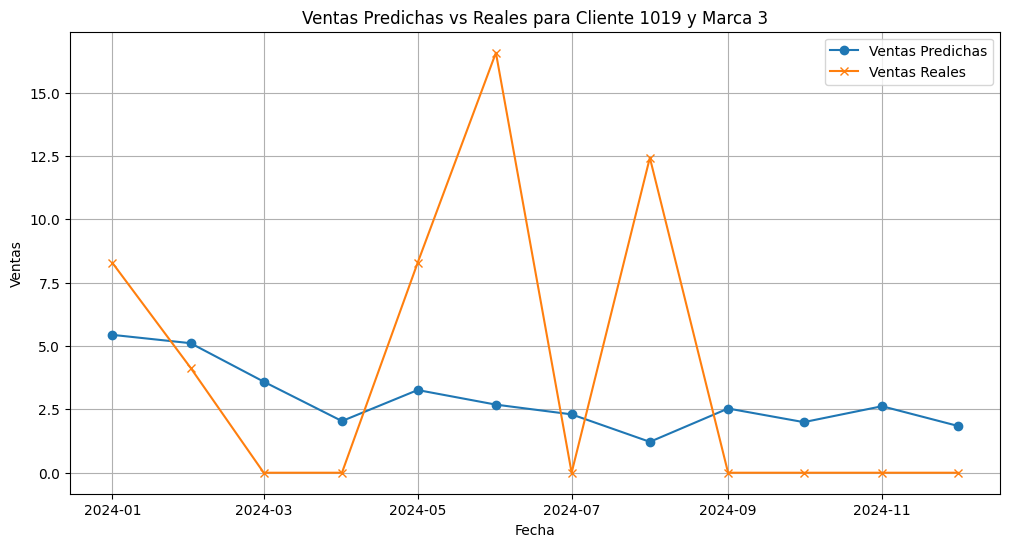

In [91]:
# Graficar
plt.figure(figsize=(12,6))
plt.plot(datos_cliente_marca['fecha_mes'], datos_cliente_marca['ventas_predichas'], label='Ventas Predichas', marker='o')
plt.plot(datos_cliente_marca['fecha_mes'], datos_cliente_marca['ventas_reales'], label='Ventas Reales', marker='x')
plt.title(f'Ventas Predichas vs Reales para Cliente {cliente_id_ejemplo} y Marca {marca_id_ejemplo}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

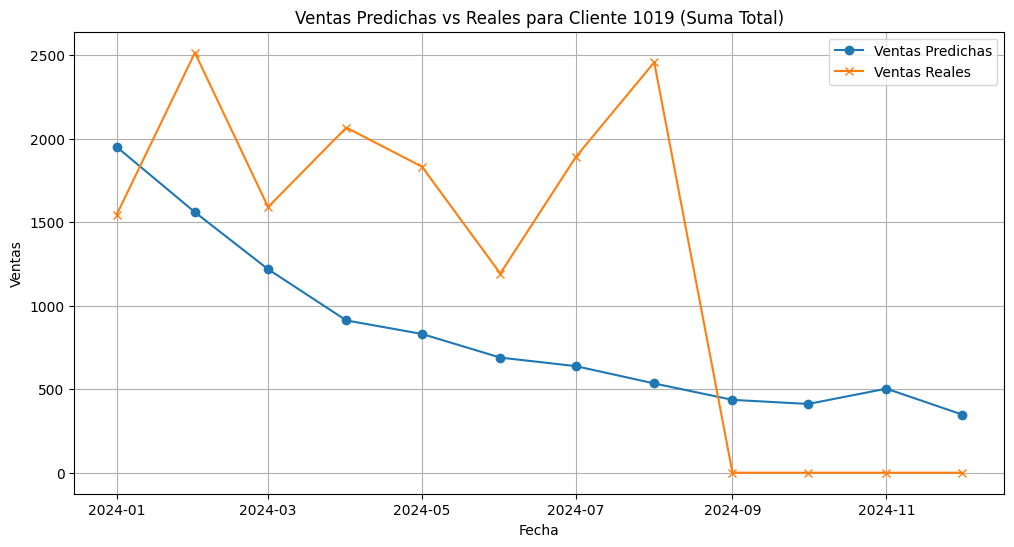

In [92]:
# Agrupar los datos por cliente y fecha, sumando las ventas predichas y las ventas reales
datos_cliente_suma = resultado[resultado['cliente_id'] == cliente_id_ejemplo].groupby('fecha_mes').agg({
    'ventas_predichas': 'sum',
    'ventas_reales': 'sum'
}).reset_index()

# Graficar la suma de ventas predichas y ventas reales por mes
plt.figure(figsize=(12,6))
plt.plot(datos_cliente_suma['fecha_mes'], datos_cliente_suma['ventas_predichas'], label='Ventas Predichas', marker='o')
plt.plot(datos_cliente_suma['fecha_mes'], datos_cliente_suma['ventas_reales'], label='Ventas Reales', marker='x')
plt.title(f'Ventas Predichas vs Reales para Cliente {cliente_id_ejemplo} (Suma Total)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Codificar la marca_id
# marca_id_ejemplo_encoded = le_marca.transform([marca_id_ejemplo])[0]
marca_id_ejemplo_encoded = marca_id_ejemplo



# Definir la fecha de inicio para los 12 meses anteriores
fecha_inicio = fecha_corte - pd.DateOffset(months=12)

# Filtrar los datos históricos para el cliente y marca seleccionados en los últimos 12 meses
datos_historicos = df_full[
    (df_full['cliente_id'] == cliente_id_ejemplo) &
    (df_full['marca_id_encoded'] == marca_id_ejemplo_encoded) &
    (df_full['fecha_mes'] >= fecha_inicio) &
    (df_full['fecha_mes'] < fecha_corte)
][['fecha_mes', 'precio_total']].copy()

# Renombrar la columna 'precio_total' a 'ventas_historicas'
datos_historicos.rename(columns={'precio_total': 'ventas_historicas'}, inplace=True)

In [94]:
# Filtrar los datos de predicción y ventas reales
datos_cliente_marca = resultado[
    (resultado['cliente_id'] == cliente_id_ejemplo) &
    (resultado['marca_id_encoded'] == marca_id_ejemplo_encoded)
][['fecha_mes', 'ventas_reales', 'ventas_predichas']]

In [95]:
# Combinar los datos
datos_combinados = pd.concat([datos_historicos, datos_cliente_marca], sort=False).sort_values('fecha_mes').reset_index(drop=True)

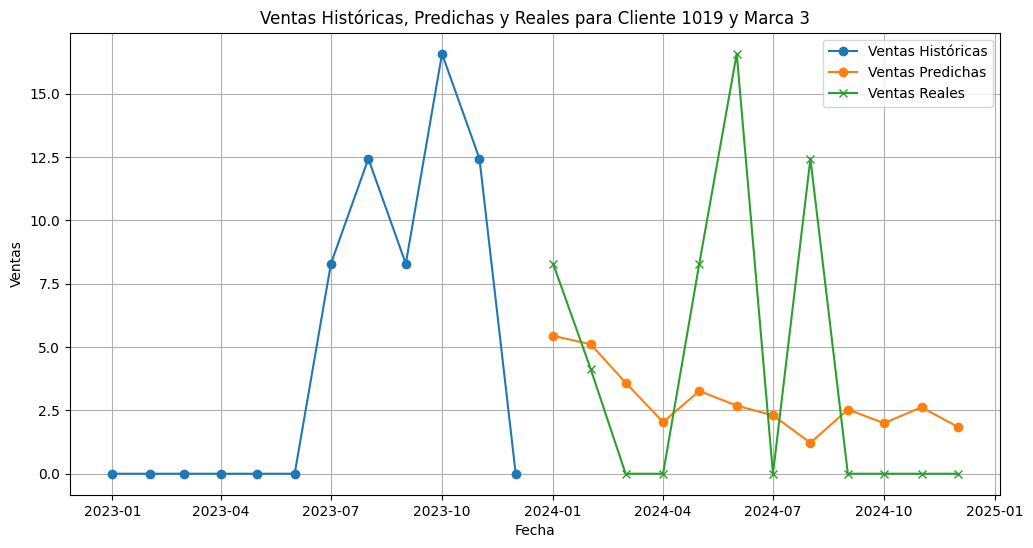

In [96]:
# Graficar
plt.figure(figsize=(12,6))

# Graficar ventas históricas
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_historicas'], label='Ventas Históricas', marker='o')

# Graficar ventas predichas
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_predichas'], label='Ventas Predichas', marker='o')

# Graficar ventas reales
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_reales'], label='Ventas Reales', marker='x')

plt.title(f'Ventas Históricas, Predichas y Reales para Cliente {cliente_id_ejemplo} y Marca {marca_id_ejemplo}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()


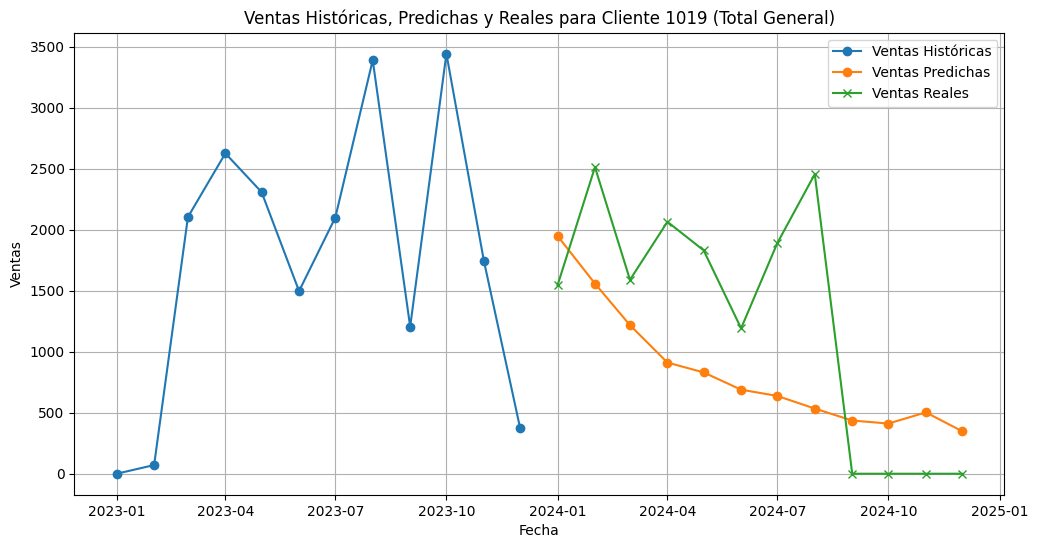

In [97]:
# Definir la fecha de inicio para los 12 meses anteriores
fecha_inicio = fecha_corte - pd.DateOffset(months=12)

# Filtrar los datos históricos para el cliente seleccionado en los últimos 12 meses y sumar las ventas de todas las marcas
datos_historicos = df_full[
    (df_full['cliente_id'] == cliente_id_ejemplo) &
    (df_full['fecha_mes'] >= fecha_inicio) & 
    (df_full['fecha_mes'] < fecha_corte)
].groupby('fecha_mes')['precio_total'].sum().reset_index()

# Renombrar la columna 'precio_total' a 'ventas_historicas'
datos_historicos.rename(columns={'precio_total': 'ventas_historicas'}, inplace=True)

# Filtrar los datos de predicción y ventas reales, y sumar las ventas de todas las marcas por mes
datos_cliente_total = resultado[
    (resultado['cliente_id'] == cliente_id_ejemplo)
].groupby('fecha_mes').agg({
    'ventas_reales': 'sum',
    'ventas_predichas': 'sum'
}).reset_index()

# Combinar datos históricos con los datos predichos y reales
datos_combinados = pd.concat([datos_historicos, datos_cliente_total], sort=False).sort_values('fecha_mes').reset_index(drop=True)

# Graficar
plt.figure(figsize=(12,6))

# Graficar ventas históricas
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_historicas'], label='Ventas Históricas', marker='o')

# Graficar ventas predichas
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_predichas'], label='Ventas Predichas', marker='o')

# Graficar ventas reales
plt.plot(datos_combinados['fecha_mes'], datos_combinados['ventas_reales'], label='Ventas Reales', marker='x')

plt.title(f'Ventas Históricas, Predichas y Reales para Cliente {cliente_id_ejemplo} (Total General)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
# os.makedirs('mapping_csvs', exist_ok=True)

# categorical_cols = ['producto_id', 'codigo_compra', 'categoria_id', 'marca_id', 'grupo_id', 'cluster_id']

# # Function to encode a single column and save mappings to CSV
# def encode_column(df, col):
#     # Get unique values and create a mapping
#     unique_values = df[col].unique()
#     mapping = {val: idx for idx, val in enumerate(unique_values)}
    
#     # Create a reverse mapping for later use
#     reverse_mapping = {v: k for k, v in mapping.items()}
    
#     # Use the mapping to encode the column
#     df[col] = df[col].map(mapping)
    
#     # Save forward mapping to CSV
#     pd.DataFrame(list(mapping.items()), columns=['Original', 'Encoded']).to_csv(f'mapping_csvs/{col}_forward_mapping.csv', index=False)
    
#     # Save reverse mapping to CSV
#     pd.DataFrame(list(reverse_mapping.items()), columns=['Encoded', 'Original']).to_csv(f'mapping_csvs/{col}_reverse_mapping.csv', index=False)
    
#     return mapping, reverse_mapping

# # Process all columns
# label_mappings = {}
# reverse_mappings = {}

# for col in tqdm(categorical_cols, desc="Encoding columns"):
#     label_mappings[col], reverse_mappings[col] = encode_column(df, col)

# print("\nLabel encoding complete. Mapping CSVs saved in 'mapping_csvs' directory.")

# # Print confirmation of saved files
# for col in categorical_cols:
#     print(f"\nMappings for {col} saved as:")
#     print(f"  - mapping_csvs/{col}_forward_mapping.csv")
#     print(f"  - mapping_csvs/{col}_reverse_mapping.csv")

# # # Como utilizar los mapeos para después.
# # for col, mapping in label_mappings.items():
# #     print(f"\nMapeo para {col}:")
# #     for encoded, original in mapping.items():
# #         print(f"{encoded}: {original}")

In [99]:
# df.head()

In [100]:
pca_data = pd.read_csv(r'D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\final_project_space\PARA ACTUALIZAR\cluster_pca_k_5.csv')

clusters = pd.read_csv(r'D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\final_project_space\PARA ACTUALIZAR\customer_clusters.csv')

In [101]:
pca_data.head()

,CustomerID,PC1,PC2,PC3,cluster
0,1043,-0.914652,-0.110685,-0.141553,2
1,1177,-0.677625,-0.373242,0.327396,2
2,1193,3.307739,-0.287169,0.155127,0
3,1196,-1.177624,-0.694545,0.226838,2
4,1232,-0.256489,-0.301070,0.076691,2


In [102]:
clusters.head()

,cluster_id,cliente_id
0,5,1019
1,5,1025
2,5,1032
3,5,1035
4,2,1043


In [103]:
# Eliminar la columna 'cluster' de pca_data
pca_data = pca_data.drop(columns=['cluster'])

# Hacer un merge con clusters para añadir la columna 'cluster_id'
pca_data = pca_data.merge(clusters, left_on='CustomerID', right_on='cliente_id', how='left')

# Opcionalmente, eliminar la columna 'cliente_id' si no la necesitas
pca_data = pca_data.drop(columns=['cliente_id'])

In [104]:
pca_data.head()

,CustomerID,PC1,PC2,PC3,cluster_id
0,1043,-0.914652,-0.110685,-0.141553,2
1,1177,-0.677625,-0.373242,0.327396,2
2,1193,3.307739,-0.287169,0.155127,0
3,1196,-1.177624,-0.694545,0.226838,2
4,1232,-0.256489,-0.301070,0.076691,2


In [105]:
pca_data.to_csv(r'D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\final_project_space\PARA ACTUALIZAR\pca_data.csv', index=False)